In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(300),
    transforms.ToTensor()
])

trainimageset = torchvision.datasets.ImageFolder("C:/Users/gwies/Documents/Programming Projects/cmse202project/Data/Train",
    transform = transform)

trainimagesloader = DataLoader(
    trainimageset,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False
 )

classes = ('C2.1','C2.2','C7.1','C7.2','C7.3')


In [2]:
testimageset = torchvision.datasets.ImageFolder("C:/Users/gwies/Documents/Programming Projects/cmse202project/Data/Validation",
    transform = transform)

testimagesloader = DataLoader(
    trainimageset,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False
 )


In [3]:
class CNet(nn.Module):

    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 40, 5) # First Conv Net 3 -> 20
        self.pool = nn.MaxPool2d( 2,  2) # MAX Pool Net Kernel == 2, Step == 2
        self.conv2 = nn.Conv2d(40, 60, 5) # Second Conv Net 20 -> 60
        self.fc1 = nn.Linear(60*72*72,120) #Fully connected layer num -> 120
        self.fc2 = nn.Linear(120, 84) #Fully connected layer 120 -> 84
        self.fc3 = nn.Linear(84,5) #Fully connected layer 84 -> 5 (outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x       

model = CNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = .9) # Standard Optimizer
criterion = nn.CrossEntropyLoss() #softmax activation function is included in this function

model = model.cuda() # Push Model to GPU
criterion= criterion.cuda() # Push criterion to GPU

print(model)

CNet(
  (conv1): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 60, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=311040, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)


In [4]:
loss_vals = []
for epoch in range(20): 
    epoch_loss = []

    for i, data in enumerate(trainimagesloader, 0):
        inputs, labels = data # Take inputs and labels out of loader
        inputs = inputs.cuda() # Push inputs to GPU
        labels = labels.cuda() # Push labels to GPU

        # CLEAR MEMORY
        optimizer.zero_grad()

        # FWD + BACK PASSES WITH SGD OPTIMIZER
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))


print('Finished Training')

Finished Training


In [5]:
correct = 0
total = 0
with torch.no_grad():
    for data in testimagesloader:
        images, labels = data
        images = images.cuda() # Push inputs to GPU
        labels = labels.cuda() # Push labels to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on some test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on some test images: 83 %


In [6]:
# PUSH MODEL BACK TO CPU
model = model.to('cuda')
inputs = inputs.to('cpu')
labels = labels.to('cpu')

# SAVE MODEL
path = './galaxy_cnet.pth'
torch.save(model.state_dict, path)

# CLEAR VRAM CACHE
torch.cuda.empty_cache()

In [8]:
from matplotlib import pyplot as plt
import numpy as np



Text(0, 0.5, 'Loss')

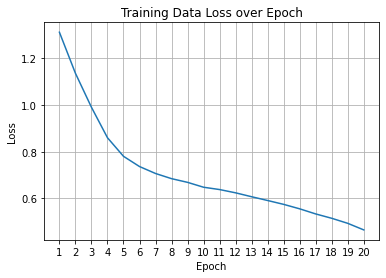

In [13]:
plt.plot(range(1,21),loss_vals)
plt.xticks(range(1,21))
plt.grid()
plt.title("Training Data Loss over Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
